In [31]:
import pandas as pd 

data = pd.read_csv('data_no_bg.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab


In [32]:
len(data.espece.unique())

14

### Création d'un échantillon 

In [2]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_35328\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_35328\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_35328\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_35328\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_35328\3821067970

In [3]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Grape,True,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,True,Early_blight
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Strawberry,True,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Soybean,False,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,False,healthy
4985,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Potato,True,Late_blight
4987,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,True,Tomato_Yellow_Leaf_Curl_Virus


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [5]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.espece.unique())

### Prétraitement des données

In [6]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="espece",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 3992 validated image filenames belonging to 14 classes.


In [8]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="espece",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 997 validated image filenames belonging to 14 classes.


### Modélisation sur l'échantillon

In [9]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
# Compilation du modèle

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 189s 3s/step - loss: 2.7609 - accuracy: 0.2961 - val_loss: 2.0839 - val_accuracy: 0.4688
Epoch 2/8
62/62 [==============================] - 180s 3s/step - loss: 1.8554 - accuracy: 0.5209 - val_loss: 1.7614 - val_accuracy: 0.5302
Epoch 3/8
62/62 [==============================] - 188s 3s/step - loss: 1.5514 - accuracy: 0.6059 - val_loss: 1.5703 - val_accuracy: 0.6187
Epoch 4/8
62/62 [==============================] - 189s 3s/step - loss: 1.3005 - accuracy: 0.6894 - val_loss: 1.4481 - val_accuracy: 0.6385
Epoch 5/8
62/62 [==============================] - 189s 3s/step - loss: 1.1546 - accuracy: 0.7457 - val_loss: 1.5956 - val_accuracy: 0.5990
Epoch 6/8
62/62 [==============================] - 180s 3s/step - loss: 1.0299 - accuracy: 0.7968 - val_loss: 1.4382 - val_accuracy: 0.6667
Epoch 7/8
62/62 [==============================] - 179s 3s/step - loss: 0.8605 - accuracy: 0.8513 - val_loss: 1.3889 - val_accuracy: 0.6927
Epoch 8/8
62/62 [===

### Généralisation à l'ensemble du dataset

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

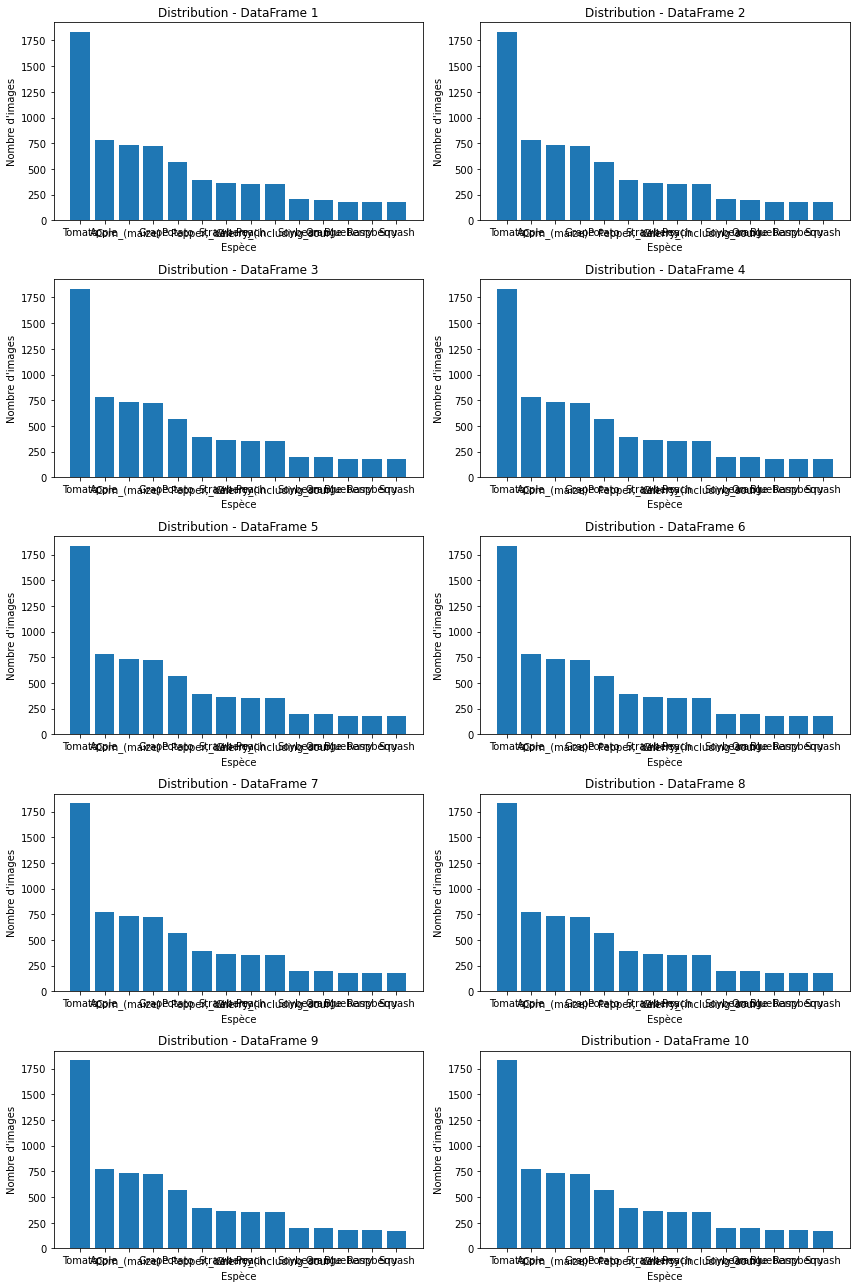

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt 

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['espece']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)

for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['espece'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Espèce")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [17]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 56

### Modélisation 

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_espece_no_bg.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.4544 - accuracy: 0.3608
Epoch 1: val_loss improved from inf to 1.80155, saving model to cnn_id_espece_no_bg.h5
87/87 [==============================] - 260s 3s/step - loss: 2.4544 - accuracy: 0.3608 - val_loss: 1.8015 - val_accuracy: 0.5097
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.6709 - accuracy: 0.5473
Epoch 2: val_loss improved from 1.80155 to 1.63960, saving model to cnn_id_espece_no_bg.h5
87/87 [==============================] - 268s 3s/step - loss: 1.6709 - accuracy: 0.5473 - val_loss: 1.6396 - val_accuracy: 0.5603
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.3855 - accuracy: 0.6435
Epoch 3: val_loss improved from 1.63960 to 1.39533, saving model to cnn_id_espece_no_bg.h5
87/87 [==============================] - 245s 3s/step - loss: 1.3855 - accuracy: 0.6435 - val_loss: 1.3953 - val_accuracy: 0.6414
Epoch 4/8
87/87 [========

Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.9682
Epoch 5: val_loss did not improve from 0.97523
87/87 [==============================] - 244s 3s/step - loss: 0.4390 - accuracy: 0.9682 - val_loss: 1.0757 - val_accuracy: 0.7984
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.9590
Epoch 6: val_loss did not improve from 0.97523
87/87 [==============================] - 241s 3s/step - loss: 0.4811 - accuracy: 0.9590 - val_loss: 1.0345 - val_accuracy: 0.8110
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.9723
Epoch 7: val_loss did not improve from 0.97523
87/87 [==============================] - 242s 3s/step - loss: 0.4553 - accuracy: 0.9723 - val_loss: 1.0971 - val_accuracy: 0.8006
Epoch 8/8
87/87 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.9642
Epoch 8: val_loss did not improve from 0.97523
87/87 [==============================] - 244s 3s/s

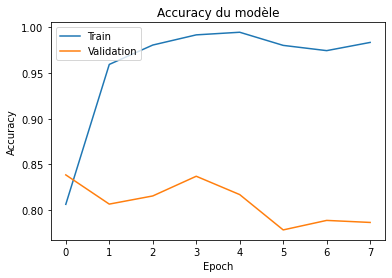

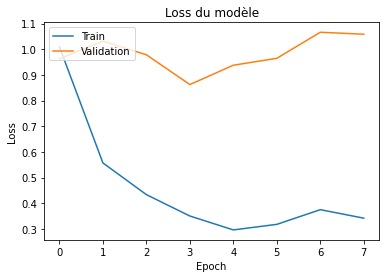

In [19]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sauvegarde du modèle

In [47]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(14, activation='softmax')
])

model.load_weights('cnn_id_espece_no_bg.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_espece_no_bg.h5')